# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import cohen_kappa_fn, f1_fn
from models import HomogeneousCNNClassifier
from optim_utils import build_optimizer_and_scheduler
from torch import nn
from torchsummary import summary
from torchvision import transforms
from training import Trainer
from visualize import Visualizer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

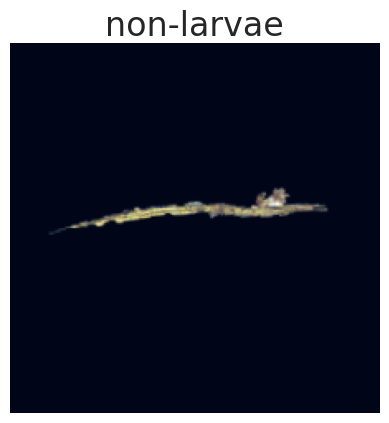

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="residual",
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              84
       BatchNorm2d-2          [-1, 3, 224, 224]               6
              ReLU-3          [-1, 3, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]             448
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
     ResidualBlock-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 112, 112]               0
            Conv2d-9         [-1, 16, 112, 112]           2,320
      BatchNorm2d-10         [-1, 16, 112, 112]              32
             ReLU-11         [-1, 16, 112, 112]               0
           Conv2d-12         [-1, 32, 112, 112]           4,640
      BatchNorm2d-13         [-1, 32, 112, 112]              64
             ReLU-14         [-1, 32, 1

In [11]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_0 = "weights/larvae-adv-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=100)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6931 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6924 | Val Loss: 0.6926 | Train cohen_kappa_fn: 0.0295 | Val cohen_kappa_fn: -0.1084 | Train f1_fn: 0.8430 | Val f1_fn: 0.7520
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6908 | Val Loss: 0.6921 | Train cohen_kappa_fn: -0.0044 | Val cohen_kappa_fn: -0.0537 | Train f1_fn: 0.9010 | Val f1_fn: 0.8866
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6882 | Val Loss: 0.6910 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6861 | Val Loss: 0.6893 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6816 | Val Loss: 0.6852 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6769 | Val Loss: 0.6782 | Train cohen_kappa_fn: 0.0220 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9163 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6648 | Val Loss: 0.6655 | Train cohen_kappa_fn: 0.0431 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9160 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6535 | Val Loss: 0.6513 | Train cohen_kappa_fn: 0.1882 | Val cohen_kappa_fn: 0.0142 | Train f1_fn: 0.9133 | Val f1_fn: 0.9113
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6340 | Val Loss: 0.6330 | Train cohen_kappa_fn: 0.4166 | Val cohen_kappa_fn: 0.0533 | Train f1_fn: 0.9104 | Val f1_fn: 0.8928
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.6106 | Val Loss: 0.6055 | Train cohen_kappa_fn: 0.4581 | Val cohen_kappa_fn: 0.4004 | Train f1_fn: 0.8944 | Val f1_fn: 0.9054
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.5888 | Val Loss: 0.5958 | Train cohen_kappa_fn: 0.5265 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.8984 | Val f1_fn: 0.9178
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.5557 | Val Loss: 0.6079 | Train cohen_kappa_fn: 0.5259 | Val cohen_kappa_fn: 0.5469 | Train f1_fn: 0.8867 | Val f1_fn: 0.8978
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.5233 | Val Loss: 0.5567 | Train cohen_kappa_fn: 0.7536 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9595 | Val f1_fn: 0.9572
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.5090 | Val Loss: 0.6329 | Train cohen_kappa_fn: 0.3098 | Val cohen_kappa_fn: 0.2053 | Train f1_fn: 0.7470 | Val f1_fn: 0.6434
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.5163 | Val Loss: 0.5460 | Train cohen_kappa_fn: 0.6981 | Val cohen_kappa_fn: 0.5489 | Train f1_fn: 0.9621 | Val f1_fn: 0.9470
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.5302 | Val Loss: 0.7252 | Train cohen_kappa_fn: 0.3083 | Val cohen_kappa_fn: 0.0972 | Train f1_fn: 0.9322 | Val f1_fn: 0.9199
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.4829 | Val Loss: 0.4931 | Train cohen_kappa_fn: 0.7632 | Val cohen_kappa_fn: 0.6925 | Train f1_fn: 0.9582 | Val f1_fn: 0.9495
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.4629 | Val Loss: 0.4953 | Train cohen_kappa_fn: 0.8147 | Val cohen_kappa_fn: 0.7405 | Train f1_fn: 0.9692 | Val f1_fn: 0.9615
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.4616 | Val Loss: 0.5699 | Train cohen_kappa_fn: 0.4603 | Val cohen_kappa_fn: 0.3668 | Train f1_fn: 0.8484 | Val f1_fn: 0.8026
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.4355 | Val Loss: 0.6447 | Train cohen_kappa_fn: 0.5525 | Val cohen_kappa_fn: 0.4767 | Train f1_fn: 0.9484 | Val f1_fn: 0.9422
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.4341 | Val Loss: 0.5107 | Train cohen_kappa_fn: 0.5571 | Val cohen_kappa_fn: 0.4646 | Train f1_fn: 0.8918 | Val f1_fn: 0.8577
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.4252 | Val Loss: 0.4895 | Train cohen_kappa_fn: 0.8716 | Val cohen_kappa_fn: 0.7464 | Train f1_fn: 0.9809 | Val f1_fn: 0.9635
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.4108 | Val Loss: 0.4696 | Train cohen_kappa_fn: 0.7502 | Val cohen_kappa_fn: 0.7409 | Train f1_fn: 0.9520 | Val f1_fn: 0.9545
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.4012 | Val Loss: 0.8580 | Train cohen_kappa_fn: 0.5198 | Val cohen_kappa_fn: 0.4098 | Train f1_fn: 0.9466 | Val f1_fn: 0.9373
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.3906 | Val Loss: 0.4682 | Train cohen_kappa_fn: 0.8549 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9760 | Val f1_fn: 0.9572
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.3980 | Val Loss: 0.8598 | Train cohen_kappa_fn: 0.5770 | Val cohen_kappa_fn: 0.5189 | Train f1_fn: 0.9512 | Val f1_fn: 0.9455
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.4120 | Val Loss: 0.6690 | Train cohen_kappa_fn: 0.0595 | Val cohen_kappa_fn: 0.0377 | Train f1_fn: 0.2911 | Val f1_fn: 0.2288
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.3924 | Val Loss: 1.5598 | Train cohen_kappa_fn: 0.3015 | Val cohen_kappa_fn: 0.0972 | Train f1_fn: 0.9323 | Val f1_fn: 0.9199
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.3843 | Val Loss: 0.7742 | Train cohen_kappa_fn: 0.5653 | Val cohen_kappa_fn: 0.5957 | Train f1_fn: 0.9506 | Val f1_fn: 0.9502
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.4010 | Val Loss: 0.4980 | Train cohen_kappa_fn: 0.8529 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9779 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.4095 | Val Loss: 0.4620 | Train cohen_kappa_fn: 0.7988 | Val cohen_kappa_fn: 0.7360 | Train f1_fn: 0.9632 | Val f1_fn: 0.9524
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.3749 | Val Loss: 0.4634 | Train cohen_kappa_fn: 0.7008 | Val cohen_kappa_fn: 0.6675 | Train f1_fn: 0.9388 | Val f1_fn: 0.9339
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.3802 | Val Loss: 0.4437 | Train cohen_kappa_fn: 0.8593 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9758 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.3705 | Val Loss: 0.5286 | Train cohen_kappa_fn: 0.8957 | Val cohen_kappa_fn: 0.8115 | Train f1_fn: 0.9837 | Val f1_fn: 0.9726
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.3751 | Val Loss: 0.4792 | Train cohen_kappa_fn: 0.5254 | Val cohen_kappa_fn: 0.5338 | Train f1_fn: 0.8778 | Val f1_fn: 0.8852
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.3732 | Val Loss: 0.4426 | Train cohen_kappa_fn: 0.7822 | Val cohen_kappa_fn: 0.7229 | Train f1_fn: 0.9592 | Val f1_fn: 0.9482
  🔥 New best model saved!


📘 Epoch 38 | Train Loss: 0.3819 | Val Loss: 1.6978 | Train cohen_kappa_fn: 0.3886 | Val cohen_kappa_fn: 0.2432 | Train f1_fn: 0.9374 | Val f1_fn: 0.9278
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.4056 | Val Loss: 0.6897 | Train cohen_kappa_fn: 0.0136 | Val cohen_kappa_fn: 0.0082 | Train f1_fn: 0.0824 | Val f1_fn: 0.0505
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.4121 | Val Loss: 0.4360 | Train cohen_kappa_fn: 0.8562 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9750 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 41 | Train Loss: 0.3806 | Val Loss: 0.6674 | Train cohen_kappa_fn: 0.8559 | Val cohen_kappa_fn: 0.6944 | Train f1_fn: 0.9796 | Val f1_fn: 0.9606
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.3791 | Val Loss: 0.7516 | Train cohen_kappa_fn: 0.8491 | Val cohen_kappa_fn: 0.6319 | Train f1_fn: 0.9789 | Val f1_fn: 0.9536
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.3780 | Val Loss: 0.4715 | Train cohen_kappa_fn: 0.8925 | Val cohen_kappa_fn: 0.7870 | Train f1_fn: 0.9819 | Val f1_fn: 0.9644
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.3623 | Val Loss: 0.4545 | Train cohen_kappa_fn: 0.8514 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9742 | Val f1_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.3578 | Val Loss: 0.4509 | Train cohen_kappa_fn: 0.8134 | Val cohen_kappa_fn: 0.7447 | Train f1_fn: 0.9664 | Val f1_fn: 0.9544
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.3478 | Val Loss: 0.6971 | Train cohen_kappa_fn: 0.8625 | Val cohen_kappa_fn: 0.7216 | Train f1_fn: 0.9802 | Val f1_fn: 0.9620
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.3337 | Val Loss: 0.4305 | Train cohen_kappa_fn: 0.8841 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9813 | Val f1_fn: 0.9682
  🔥 New best model saved!


📘 Epoch 48 | Train Loss: 0.3020 | Val Loss: 0.3574 | Train cohen_kappa_fn: 0.8493 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9734 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 49 | Train Loss: 0.2698 | Val Loss: 0.5608 | Train cohen_kappa_fn: 0.8489 | Val cohen_kappa_fn: 0.7158 | Train f1_fn: 0.9753 | Val f1_fn: 0.9578
  ❄️ No improvement, model won't be saved!


📘 Epoch 50 | Train Loss: 0.1979 | Val Loss: 1.3300 | Train cohen_kappa_fn: 0.6114 | Val cohen_kappa_fn: 0.5189 | Train f1_fn: 0.9539 | Val f1_fn: 0.9455
  ❄️ No improvement, model won't be saved!


📘 Epoch 51 | Train Loss: 0.1796 | Val Loss: 0.2235 | Train cohen_kappa_fn: 0.8576 | Val cohen_kappa_fn: 0.7535 | Train f1_fn: 0.9759 | Val f1_fn: 0.9564
  🔥 New best model saved!


📘 Epoch 52 | Train Loss: 0.2419 | Val Loss: 0.2224 | Train cohen_kappa_fn: 0.7023 | Val cohen_kappa_fn: 0.6448 | Train f1_fn: 0.9387 | Val f1_fn: 0.9225
  🔥 New best model saved!


📘 Epoch 53 | Train Loss: 0.1943 | Val Loss: 0.2125 | Train cohen_kappa_fn: 0.6642 | Val cohen_kappa_fn: 0.6878 | Train f1_fn: 0.9277 | Val f1_fn: 0.9352
  🔥 New best model saved!


📘 Epoch 54 | Train Loss: 0.1474 | Val Loss: 0.4140 | Train cohen_kappa_fn: 0.9175 | Val cohen_kappa_fn: 0.8255 | Train f1_fn: 0.9874 | Val f1_fn: 0.9744
  ❄️ No improvement, model won't be saved!


📘 Epoch 55 | Train Loss: 0.1560 | Val Loss: 0.2314 | Train cohen_kappa_fn: 0.8721 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9781 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 56 | Train Loss: 0.1657 | Val Loss: 0.1986 | Train cohen_kappa_fn: 0.7530 | Val cohen_kappa_fn: 0.7224 | Train f1_fn: 0.9519 | Val f1_fn: 0.9457
  🔥 New best model saved!


📘 Epoch 57 | Train Loss: 0.1338 | Val Loss: 0.2466 | Train cohen_kappa_fn: 0.6393 | Val cohen_kappa_fn: 0.6588 | Train f1_fn: 0.9200 | Val f1_fn: 0.9267
  ❄️ No improvement, model won't be saved!


📘 Epoch 58 | Train Loss: 0.1007 | Val Loss: 0.7044 | Train cohen_kappa_fn: 0.8828 | Val cohen_kappa_fn: 0.7635 | Train f1_fn: 0.9832 | Val f1_fn: 0.9674
  ❄️ No improvement, model won't be saved!


📘 Epoch 59 | Train Loss: 0.1411 | Val Loss: 0.4349 | Train cohen_kappa_fn: 0.9318 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9897 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!


📘 Epoch 60 | Train Loss: 0.1380 | Val Loss: 0.2637 | Train cohen_kappa_fn: 0.9305 | Val cohen_kappa_fn: 0.8686 | Train f1_fn: 0.9888 | Val f1_fn: 0.9797
  ❄️ No improvement, model won't be saved!


📘 Epoch 61 | Train Loss: 0.1709 | Val Loss: 1.0357 | Train cohen_kappa_fn: 0.1063 | Val cohen_kappa_fn: 0.0918 | Train f1_fn: 0.4357 | Val f1_fn: 0.3929
  ❄️ No improvement, model won't be saved!


📘 Epoch 62 | Train Loss: 0.1797 | Val Loss: 2.5689 | Train cohen_kappa_fn: 0.3983 | Val cohen_kappa_fn: 0.1871 | Train f1_fn: 0.9381 | Val f1_fn: 0.9247
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 63 | Train Loss: 0.1577 | Val Loss: 6.4220 | Train cohen_kappa_fn: 0.0406 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9184 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


📘 Epoch 64 | Train Loss: 0.1616 | Val Loss: 0.5985 | Train cohen_kappa_fn: 0.2917 | Val cohen_kappa_fn: 0.2295 | Train f1_fn: 0.7276 | Val f1_fn: 0.6650
  ❄️ No improvement, model won't be saved!


📘 Epoch 65 | Train Loss: 0.1525 | Val Loss: 0.3509 | Train cohen_kappa_fn: 0.4960 | Val cohen_kappa_fn: 0.4074 | Train f1_fn: 0.8646 | Val f1_fn: 0.8192
  ❄️ No improvement, model won't be saved!


📘 Epoch 66 | Train Loss: 0.1413 | Val Loss: 0.2769 | Train cohen_kappa_fn: 0.9179 | Val cohen_kappa_fn: 0.8367 | Train f1_fn: 0.9865 | Val f1_fn: 0.9740
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


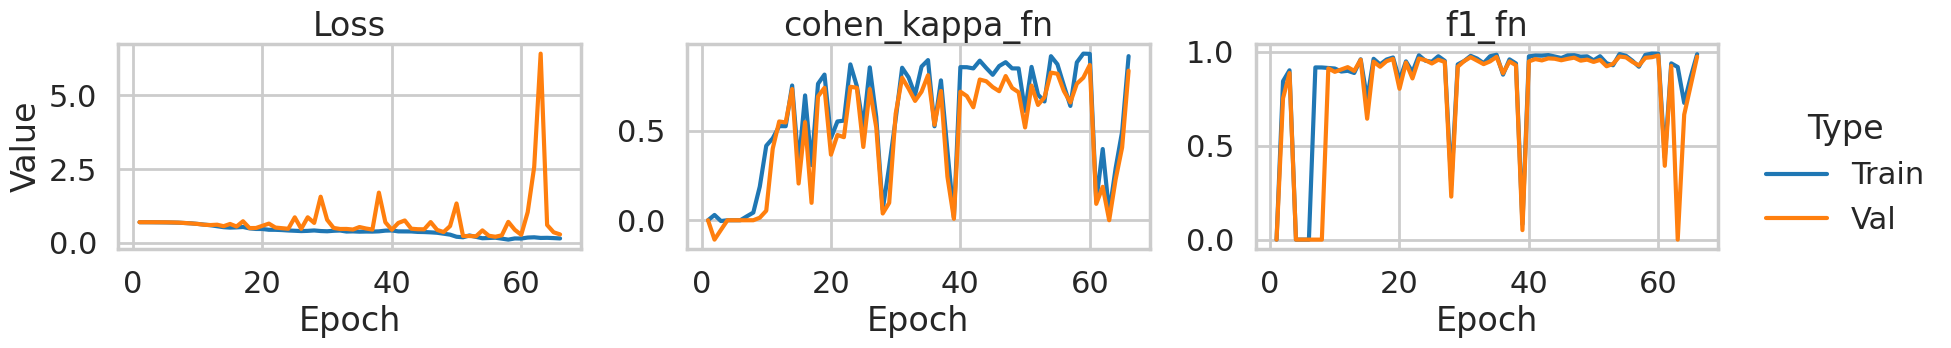

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1568 | Test cohen_kappa_fn: 0.7579 | Test f1_fn: 0.9537


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

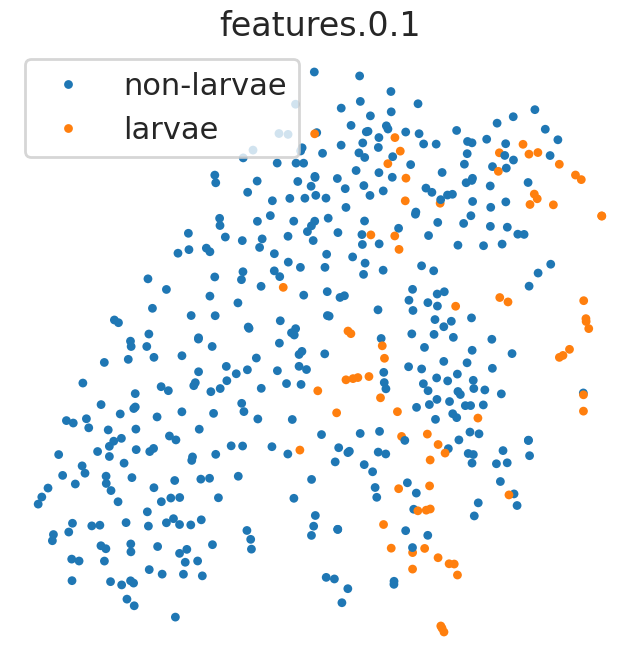

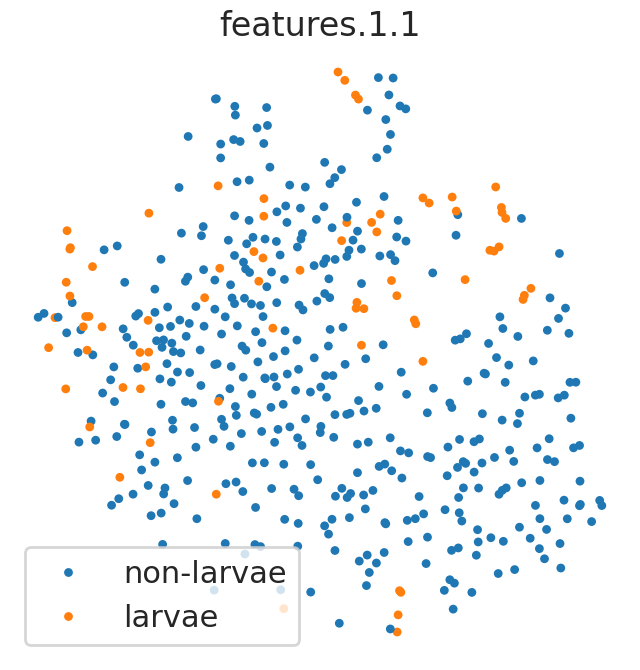

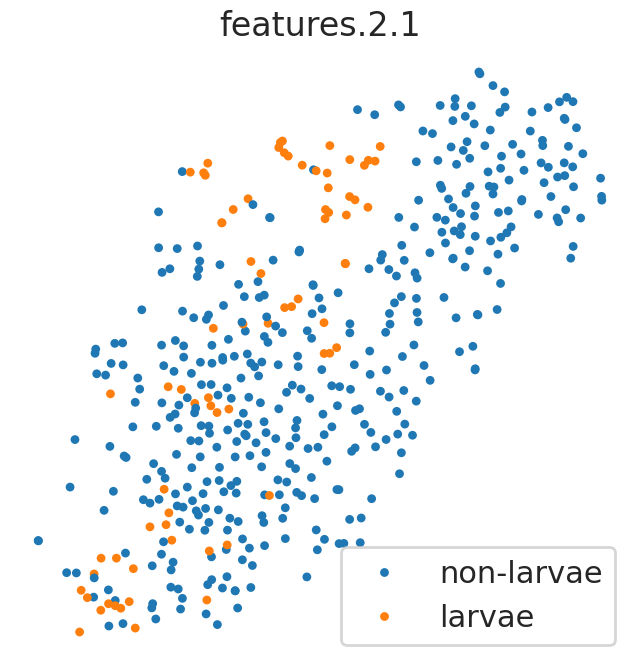

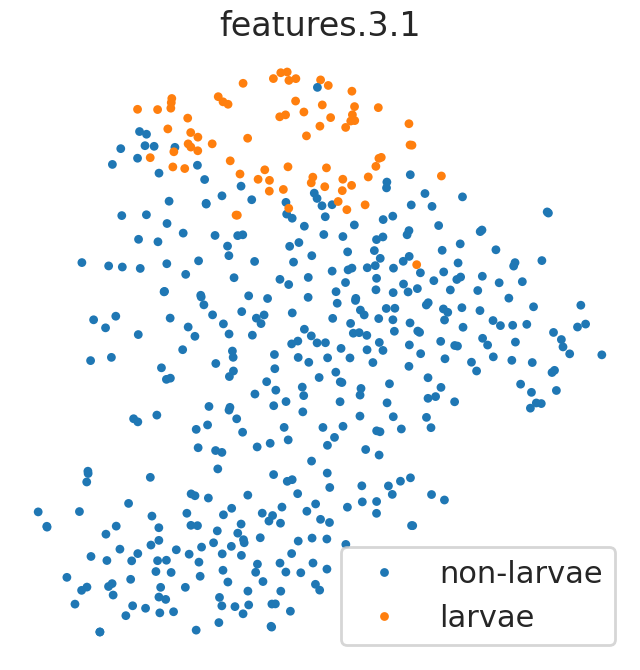

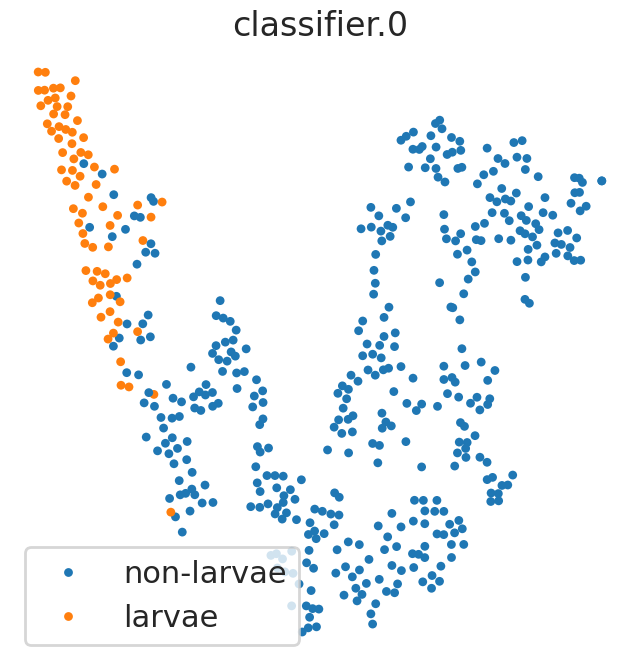

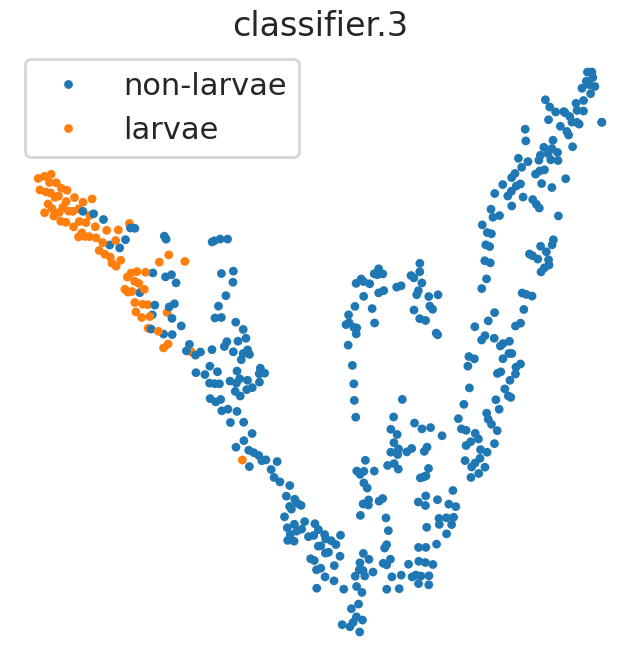

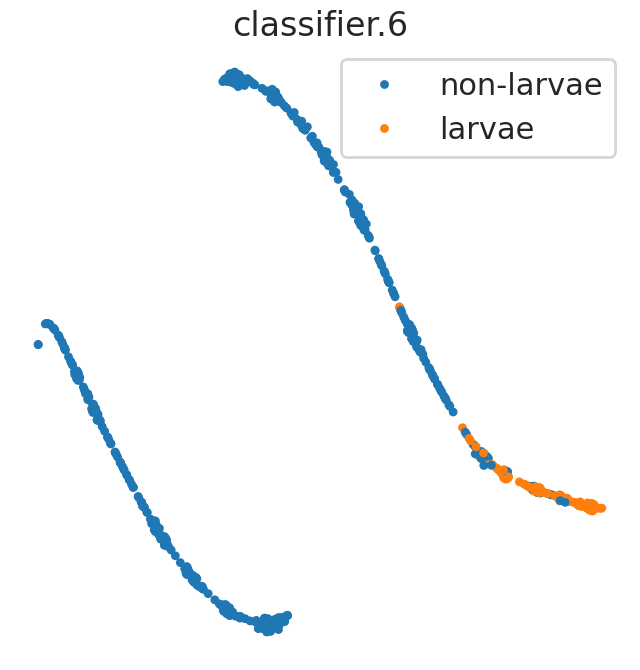

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


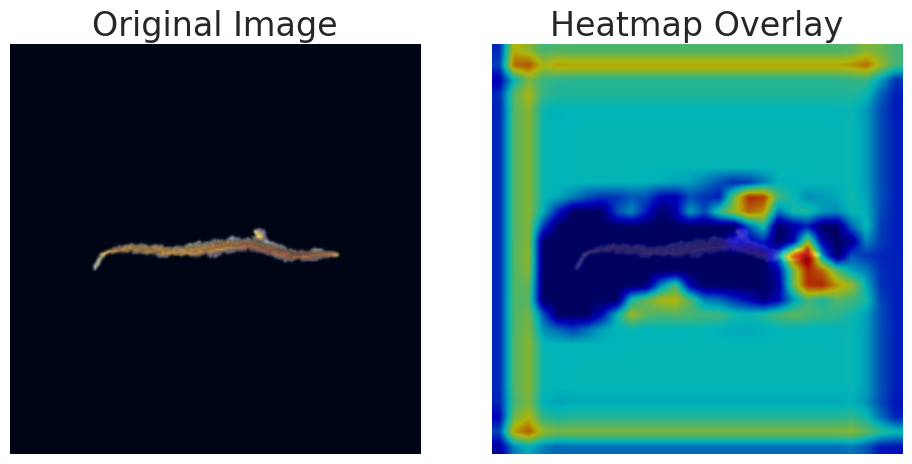

  Generating heatmap for Larvae...
  Predicted label is Larvae!


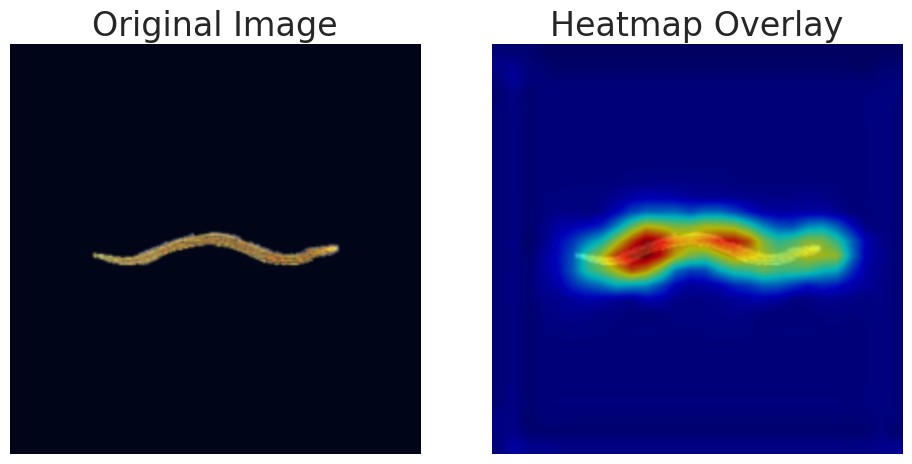

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="inception",
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              16
            Conv2d-2          [-1, 4, 224, 224]              16
            Conv2d-3          [-1, 4, 224, 224]             148
            Conv2d-4          [-1, 4, 224, 224]              16
            Conv2d-5          [-1, 4, 224, 224]             404
         MaxPool2d-6          [-1, 3, 224, 224]               0
            Conv2d-7          [-1, 4, 224, 224]              16
       BatchNorm2d-8         [-1, 16, 224, 224]              32
    InceptionBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
           Conv2d-11          [-1, 8, 112, 112]             136
           Conv2d-12          [-1, 8, 112, 112]             136
           Conv2d-13          [-1, 8, 112, 112]             584
           Conv2d-14          [-1, 8, 1

In [19]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6929 | Val Loss: 0.6927 | Train cohen_kappa_fn: 0.1961 | Val cohen_kappa_fn: 0.3244 | Train f1_fn: 0.8258 | Val f1_fn: 0.9225
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6922 | Val Loss: 0.6917 | Train cohen_kappa_fn: 0.1439 | Val cohen_kappa_fn: 0.1334 | Train f1_fn: 0.5330 | Val f1_fn: 0.5257
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6904 | Val Loss: 0.6899 | Train cohen_kappa_fn: 0.1360 | Val cohen_kappa_fn: 0.1136 | Train f1_fn: 0.5345 | Val f1_fn: 0.5149
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6879 | Val Loss: 0.6867 | Train cohen_kappa_fn: 0.1784 | Val cohen_kappa_fn: 0.1556 | Train f1_fn: 0.6216 | Val f1_fn: 0.6041
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6846 | Val Loss: 0.6824 | Train cohen_kappa_fn: 0.1812 | Val cohen_kappa_fn: 0.1696 | Train f1_fn: 0.6470 | Val f1_fn: 0.6250
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6788 | Val Loss: 0.6762 | Train cohen_kappa_fn: 0.1756 | Val cohen_kappa_fn: 0.1726 | Train f1_fn: 0.6307 | Val f1_fn: 0.6071
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6722 | Val Loss: 0.6662 | Train cohen_kappa_fn: 0.2072 | Val cohen_kappa_fn: 0.1820 | Train f1_fn: 0.6686 | Val f1_fn: 0.6212
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6614 | Val Loss: 0.6519 | Train cohen_kappa_fn: 0.2112 | Val cohen_kappa_fn: 0.1726 | Train f1_fn: 0.6660 | Val f1_fn: 0.6071
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6461 | Val Loss: 0.6317 | Train cohen_kappa_fn: 0.2849 | Val cohen_kappa_fn: 0.2750 | Train f1_fn: 0.7570 | Val f1_fn: 0.7373
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6260 | Val Loss: 0.6060 | Train cohen_kappa_fn: 0.3133 | Val cohen_kappa_fn: 0.2981 | Train f1_fn: 0.7841 | Val f1_fn: 0.7574
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.6037 | Val Loss: 0.5864 | Train cohen_kappa_fn: 0.2583 | Val cohen_kappa_fn: 0.2375 | Train f1_fn: 0.7215 | Val f1_fn: 0.6748
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.5708 | Val Loss: 0.5482 | Train cohen_kappa_fn: 0.3358 | Val cohen_kappa_fn: 0.2972 | Train f1_fn: 0.7912 | Val f1_fn: 0.7436
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.5392 | Val Loss: 0.5036 | Train cohen_kappa_fn: 0.3950 | Val cohen_kappa_fn: 0.3990 | Train f1_fn: 0.8389 | Val f1_fn: 0.8140
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.5015 | Val Loss: 0.4578 | Train cohen_kappa_fn: 0.5501 | Val cohen_kappa_fn: 0.5648 | Train f1_fn: 0.9181 | Val f1_fn: 0.9171
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.4642 | Val Loss: 0.4192 | Train cohen_kappa_fn: 0.5886 | Val cohen_kappa_fn: 0.6662 | Train f1_fn: 0.9279 | Val f1_fn: 0.9436
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.4330 | Val Loss: 0.3931 | Train cohen_kappa_fn: 0.6729 | Val cohen_kappa_fn: 0.7201 | Train f1_fn: 0.9469 | Val f1_fn: 0.9554
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4053 | Val Loss: 0.3500 | Train cohen_kappa_fn: 0.6869 | Val cohen_kappa_fn: 0.6748 | Train f1_fn: 0.9463 | Val f1_fn: 0.9456
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3683 | Val Loss: 0.3498 | Train cohen_kappa_fn: 0.7117 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9574 | Val f1_fn: 0.9612
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3380 | Val Loss: 0.3831 | Train cohen_kappa_fn: 0.6791 | Val cohen_kappa_fn: 0.7109 | Train f1_fn: 0.9574 | Val f1_fn: 0.9580
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3004 | Val Loss: 0.3577 | Train cohen_kappa_fn: 0.7300 | Val cohen_kappa_fn: 0.7060 | Train f1_fn: 0.9612 | Val f1_fn: 0.9559
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2984 | Val Loss: 0.4340 | Train cohen_kappa_fn: 0.6354 | Val cohen_kappa_fn: 0.7006 | Train f1_fn: 0.9550 | Val f1_fn: 0.9583
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2930 | Val Loss: 0.3623 | Train cohen_kappa_fn: 0.7218 | Val cohen_kappa_fn: 0.6867 | Train f1_fn: 0.9597 | Val f1_fn: 0.9520
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2835 | Val Loss: 0.3866 | Train cohen_kappa_fn: 0.7031 | Val cohen_kappa_fn: 0.7161 | Train f1_fn: 0.9602 | Val f1_fn: 0.9600
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2919 | Val Loss: 0.2888 | Train cohen_kappa_fn: 0.6987 | Val cohen_kappa_fn: 0.6203 | Train f1_fn: 0.9419 | Val f1_fn: 0.9290
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.3096 | Val Loss: 0.5015 | Train cohen_kappa_fn: 0.6580 | Val cohen_kappa_fn: 0.6729 | Train f1_fn: 0.9562 | Val f1_fn: 0.9568
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.3032 | Val Loss: 0.2980 | Train cohen_kappa_fn: 0.6702 | Val cohen_kappa_fn: 0.5619 | Train f1_fn: 0.9355 | Val f1_fn: 0.9098
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2520 | Val Loss: 0.3466 | Train cohen_kappa_fn: 0.7432 | Val cohen_kappa_fn: 0.7259 | Train f1_fn: 0.9644 | Val f1_fn: 0.9597
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2621 | Val Loss: 0.3446 | Train cohen_kappa_fn: 0.7798 | Val cohen_kappa_fn: 0.7013 | Train f1_fn: 0.9677 | Val f1_fn: 0.9538
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.3002 | Val Loss: 0.4630 | Train cohen_kappa_fn: 0.7419 | Val cohen_kappa_fn: 0.7110 | Train f1_fn: 0.9653 | Val f1_fn: 0.9601
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2272 | Val Loss: 0.3301 | Train cohen_kappa_fn: 0.8055 | Val cohen_kappa_fn: 0.7405 | Train f1_fn: 0.9713 | Val f1_fn: 0.9615
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2143 | Val Loss: 0.3697 | Train cohen_kappa_fn: 0.7941 | Val cohen_kappa_fn: 0.7570 | Train f1_fn: 0.9708 | Val f1_fn: 0.9654
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2053 | Val Loss: 0.6031 | Train cohen_kappa_fn: 0.6542 | Val cohen_kappa_fn: 0.6139 | Train f1_fn: 0.9571 | Val f1_fn: 0.9519
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1898 | Val Loss: 0.5072 | Train cohen_kappa_fn: 0.7207 | Val cohen_kappa_fn: 0.7165 | Train f1_fn: 0.9641 | Val f1_fn: 0.9622
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1973 | Val Loss: 0.6538 | Train cohen_kappa_fn: 0.6613 | Val cohen_kappa_fn: 0.6062 | Train f1_fn: 0.9578 | Val f1_fn: 0.9520
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


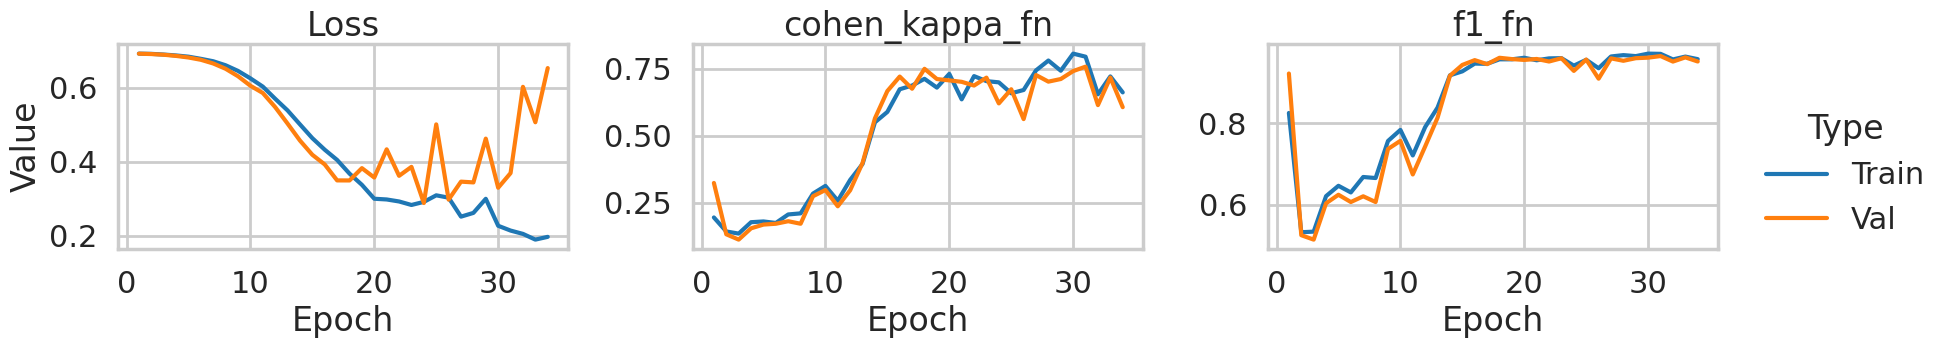

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2694 | Test cohen_kappa_fn: 0.6522 | Test f1_fn: 0.9347


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

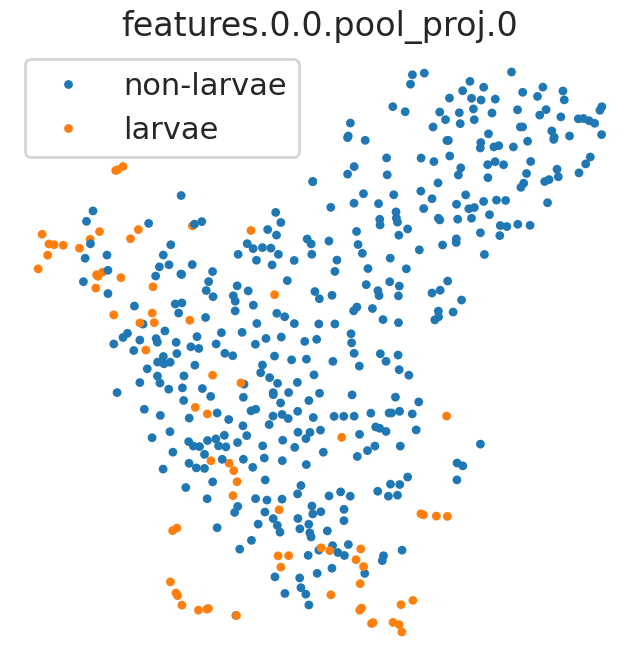

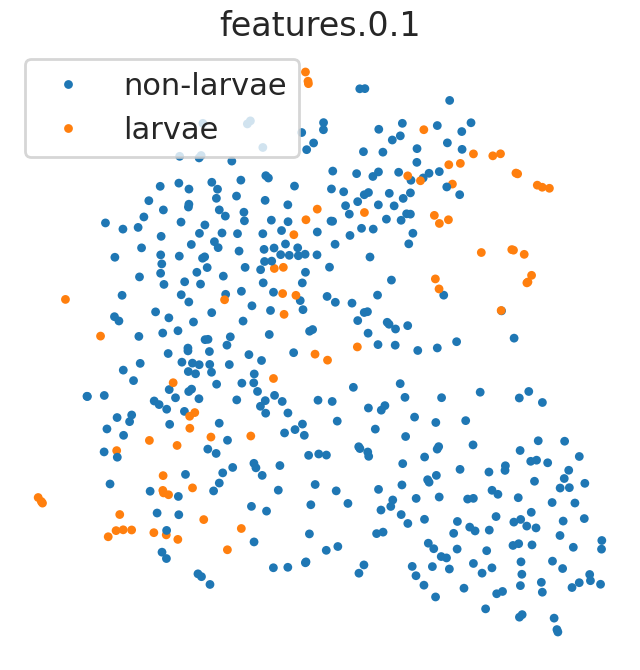

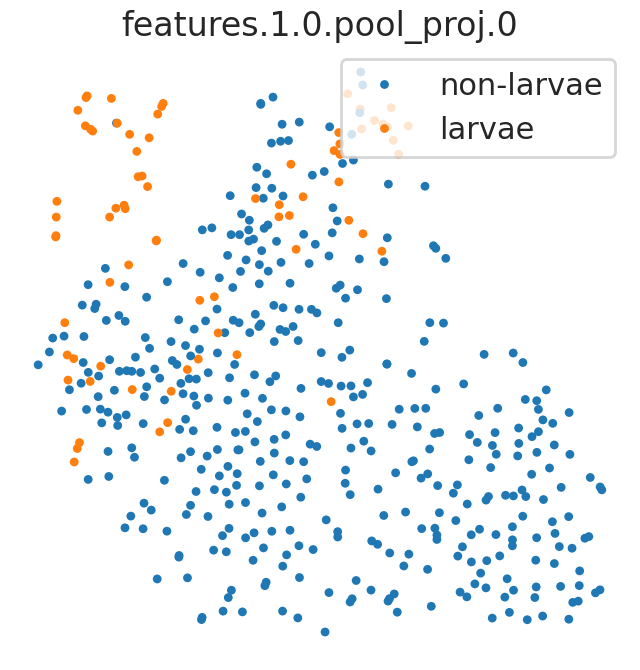

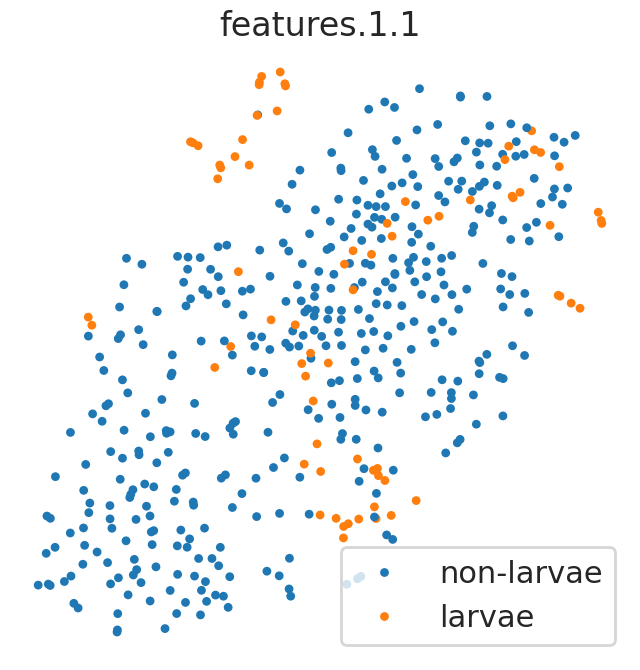

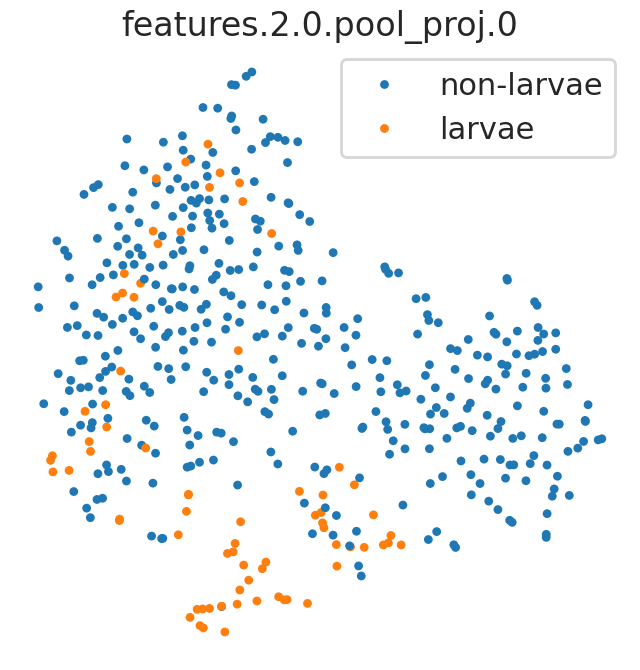

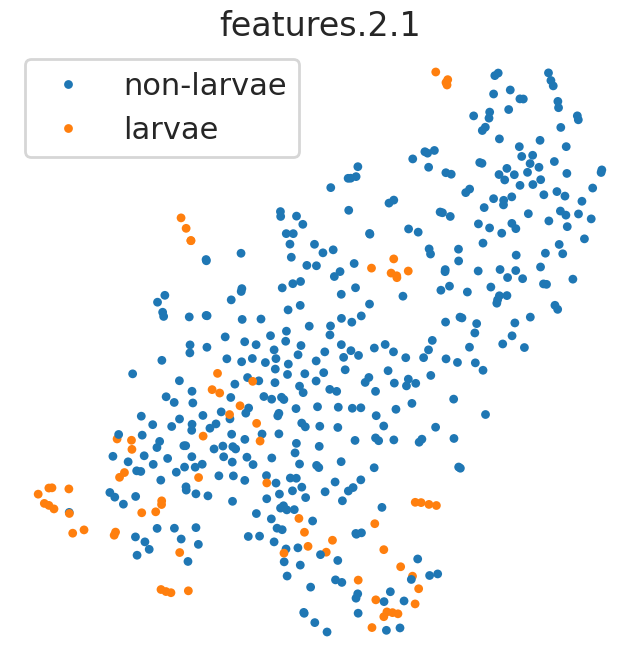

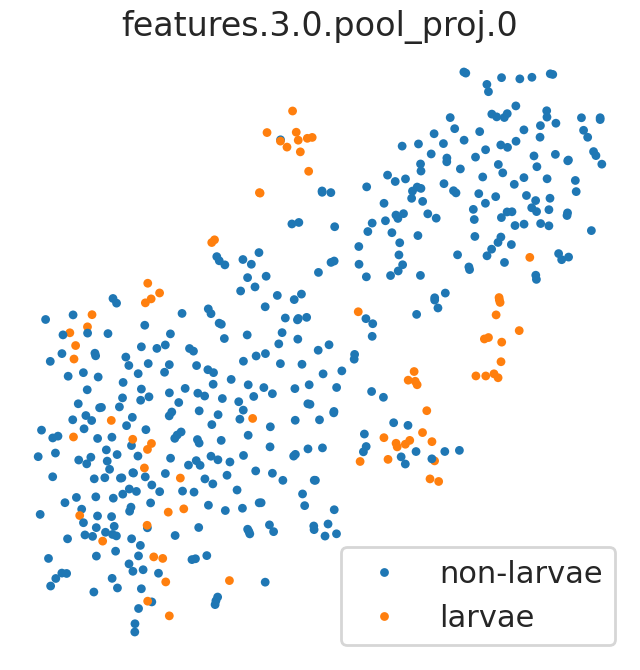

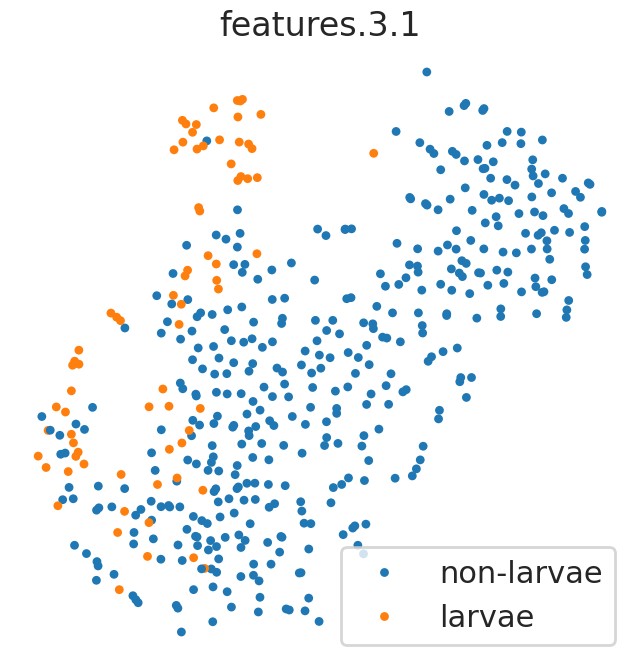

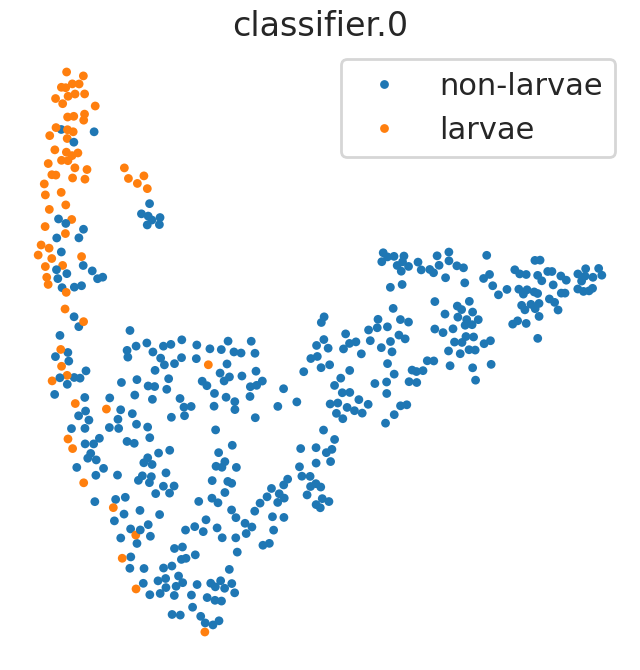

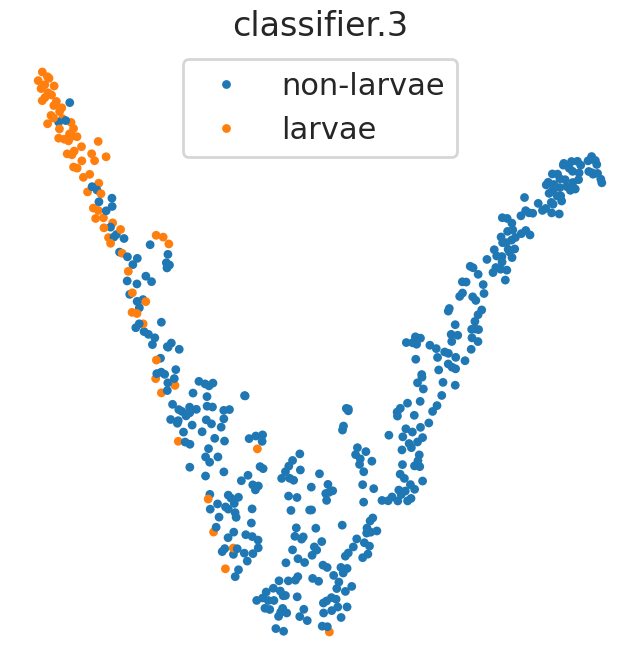

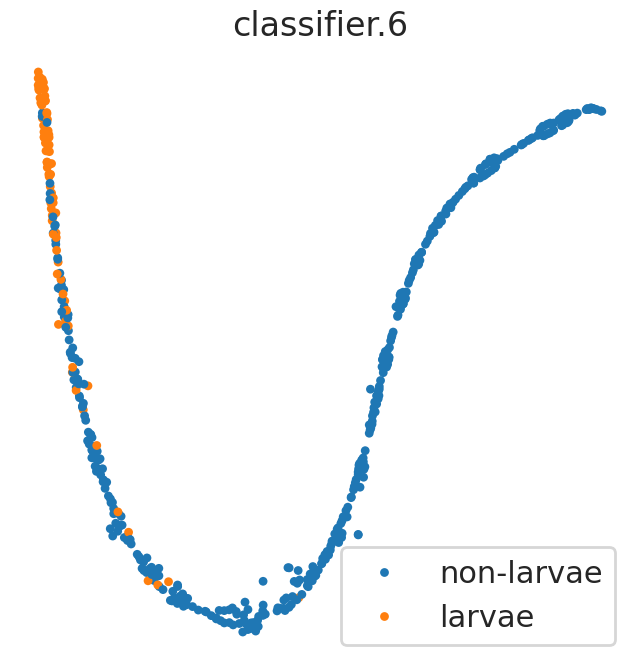

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


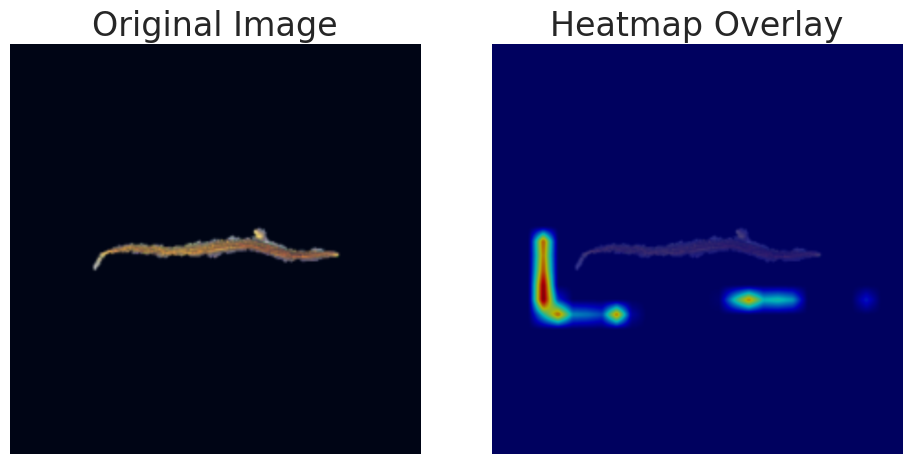

  Generating heatmap for Larvae...
  Predicted label is Larvae!


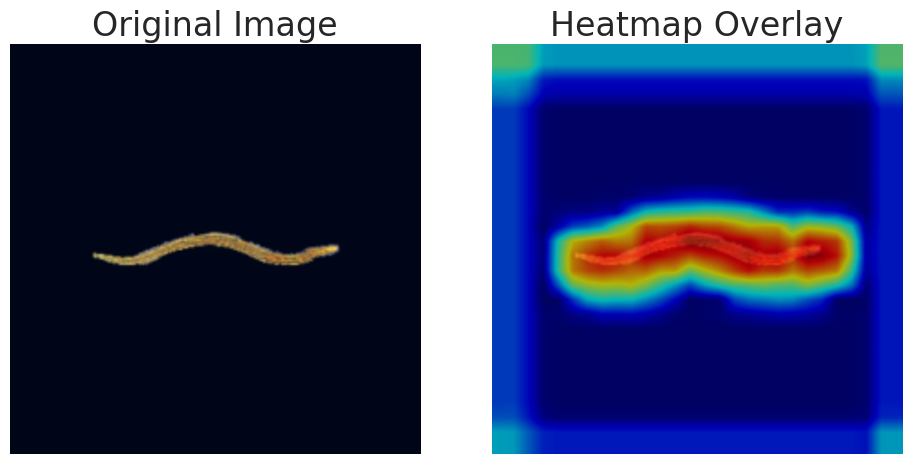

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
    device=device,
)
summary(cnn_2, input_shape)

RuntimeError: Given groups=1, weight of size [16, 3, 1, 1], expected input[1, 16, 224, 224] to have 3 channels, but got 16 channels instead

In [ ]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_2 = "weights/larvae-adv-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [ ]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=100)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6932 | Val Loss: 0.6932 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 9 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 10 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 11 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 12 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 13 | Train Loss: 0.6931 | Val Loss: 0.6932 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 14 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 15 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 16 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


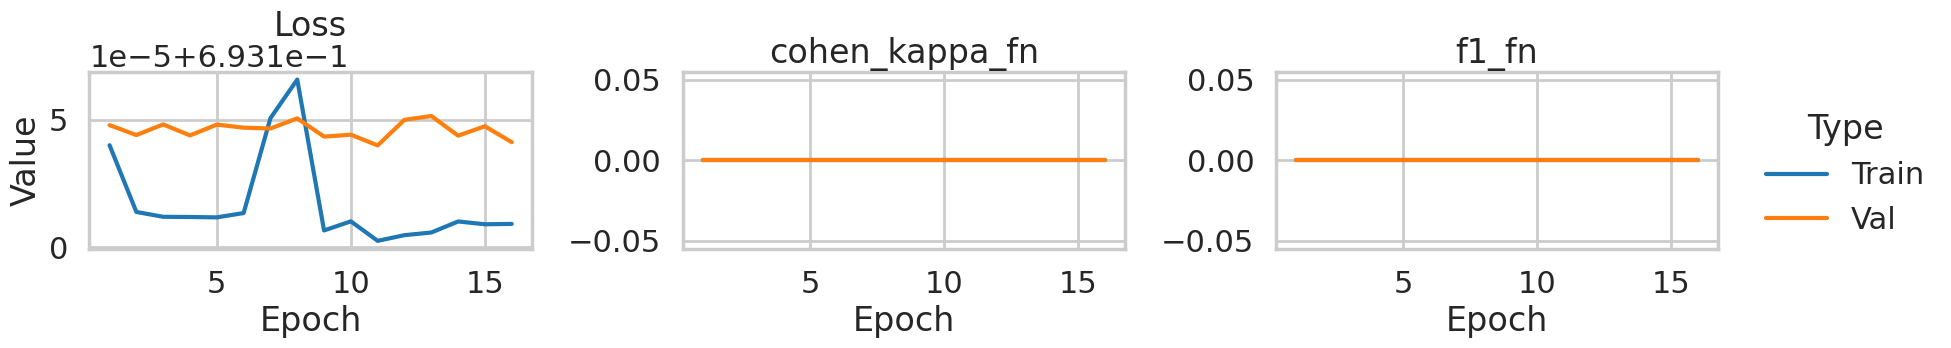

In [ ]:
trainer_cnn_2.plot_epochs()

In [ ]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
Test Loss: 0.6931 | Test cohen_kappa_fn: 0.0000 | Test f1_fn: 0.0000


#### Visualization

In [ ]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [ ]:
# Display layer representations
# visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


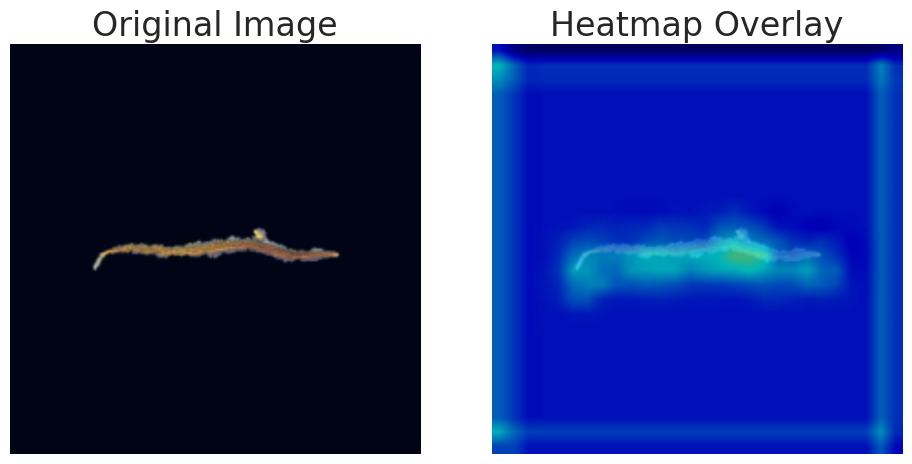

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


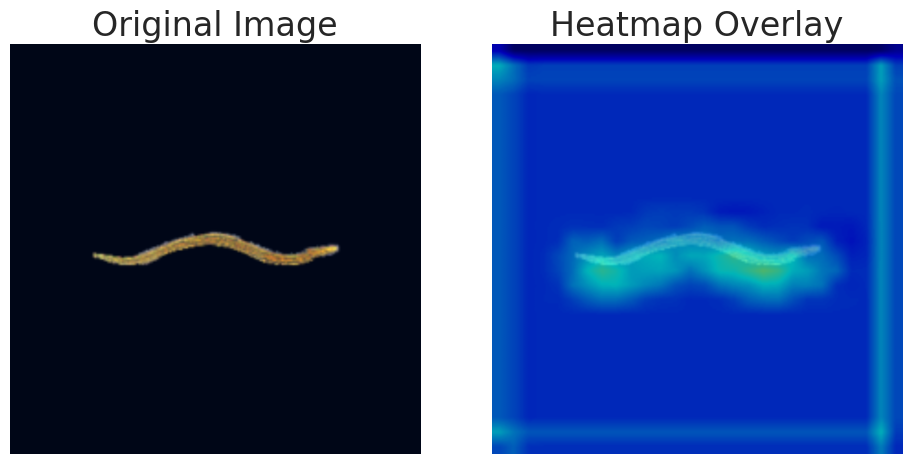

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [ ]:
cnn_3 = HomogeneousCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveMaxPool2d-3             [-1, 16, 1, 1]               0
 AdaptiveAvgPool2d-4             [-1, 16, 1, 1]               0
            Conv2d-5              [-1, 1, 1, 1]              16
              ReLU-6              [-1, 1, 1, 1]               0
            Conv2d-7             [-1, 16, 1, 1]              16
            Conv2d-8              [-1, 1, 1, 1]              16
              ReLU-9              [-1, 1, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]              16
          Sigmoid-11             [-1, 16, 1, 1]               0
 ChannelAttention-12             [-1, 16, 1, 1]               0
           Conv2d-13          [-1, 1, 224, 224]              99
          Sigmoid-14          [-1, 1, 2

In [ ]:
cbam_optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-3,
    "lr": 3e-4,
    "eta_min": 5e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(
    cnn_3,
    cbam_optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_3 = "weights/larvae-adv-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [ ]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=100)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6930 | Val Loss: 0.6932 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6939 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6931 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6928 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6926 | Val Loss: 0.6924 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6917 | Val Loss: 0.6910 | Train cohen_kappa_fn: 0.0667 | Val cohen_kappa_fn: 0.0913 | Train f1_fn: 0.3167 | Val f1_fn: 0.4106
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6897 | Val Loss: 0.6859 | Train cohen_kappa_fn: 0.0790 | Val cohen_kappa_fn: 0.1016 | Train f1_fn: 0.3745 | Val f1_fn: 0.4380
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6846 | Val Loss: 0.6802 | Train cohen_kappa_fn: 0.1110 | Val cohen_kappa_fn: 0.0142 | Train f1_fn: 0.8841 | Val f1_fn: 0.9113
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.6732 | Val Loss: 0.6546 | Train cohen_kappa_fn: 0.1426 | Val cohen_kappa_fn: 0.1529 | Train f1_fn: 0.5526 | Val f1_fn: 0.5876
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.6617 | Val Loss: 0.6274 | Train cohen_kappa_fn: 0.1153 | Val cohen_kappa_fn: 0.1313 | Train f1_fn: 0.4781 | Val f1_fn: 0.5069
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.6039 | Val Loss: 0.6223 | Train cohen_kappa_fn: 0.2492 | Val cohen_kappa_fn: 0.1708 | Train f1_fn: 0.7600 | Val f1_fn: 0.7505
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.5258 | Val Loss: 0.4047 | Train cohen_kappa_fn: 0.2859 | Val cohen_kappa_fn: 0.4766 | Train f1_fn: 0.7417 | Val f1_fn: 0.8790
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.4671 | Val Loss: 0.5308 | Train cohen_kappa_fn: 0.6550 | Val cohen_kappa_fn: 0.6197 | Train f1_fn: 0.9363 | Val f1_fn: 0.9453
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3862 | Val Loss: 0.3276 | Train cohen_kappa_fn: 0.3694 | Val cohen_kappa_fn: 0.4772 | Train f1_fn: 0.8018 | Val f1_fn: 0.8763
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3522 | Val Loss: 0.2896 | Train cohen_kappa_fn: 0.6374 | Val cohen_kappa_fn: 0.6596 | Train f1_fn: 0.9283 | Val f1_fn: 0.9392
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3203 | Val Loss: 0.2606 | Train cohen_kappa_fn: 0.7032 | Val cohen_kappa_fn: 0.7609 | Train f1_fn: 0.9456 | Val f1_fn: 0.9607
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2561 | Val Loss: 0.2868 | Train cohen_kappa_fn: 0.7597 | Val cohen_kappa_fn: 0.7630 | Train f1_fn: 0.9593 | Val f1_fn: 0.9630
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3362 | Val Loss: 0.2465 | Train cohen_kappa_fn: 0.6515 | Val cohen_kappa_fn: 0.6906 | Train f1_fn: 0.9265 | Val f1_fn: 0.9400
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2772 | Val Loss: 0.2438 | Train cohen_kappa_fn: 0.7728 | Val cohen_kappa_fn: 0.7645 | Train f1_fn: 0.9606 | Val f1_fn: 0.9606
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2338 | Val Loss: 0.4416 | Train cohen_kappa_fn: 0.3984 | Val cohen_kappa_fn: 0.3005 | Train f1_fn: 0.8130 | Val f1_fn: 0.7465
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3478 | Val Loss: 0.3208 | Train cohen_kappa_fn: 0.5041 | Val cohen_kappa_fn: 0.4854 | Train f1_fn: 0.8696 | Val f1_fn: 0.8643
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2945 | Val Loss: 0.2810 | Train cohen_kappa_fn: 0.6595 | Val cohen_kappa_fn: 0.6526 | Train f1_fn: 0.9301 | Val f1_fn: 0.9297
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2182 | Val Loss: 0.3042 | Train cohen_kappa_fn: 0.8032 | Val cohen_kappa_fn: 0.7630 | Train f1_fn: 0.9678 | Val f1_fn: 0.9630
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2308 | Val Loss: 0.2618 | Train cohen_kappa_fn: 0.7952 | Val cohen_kappa_fn: 0.7704 | Train f1_fn: 0.9644 | Val f1_fn: 0.9627
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


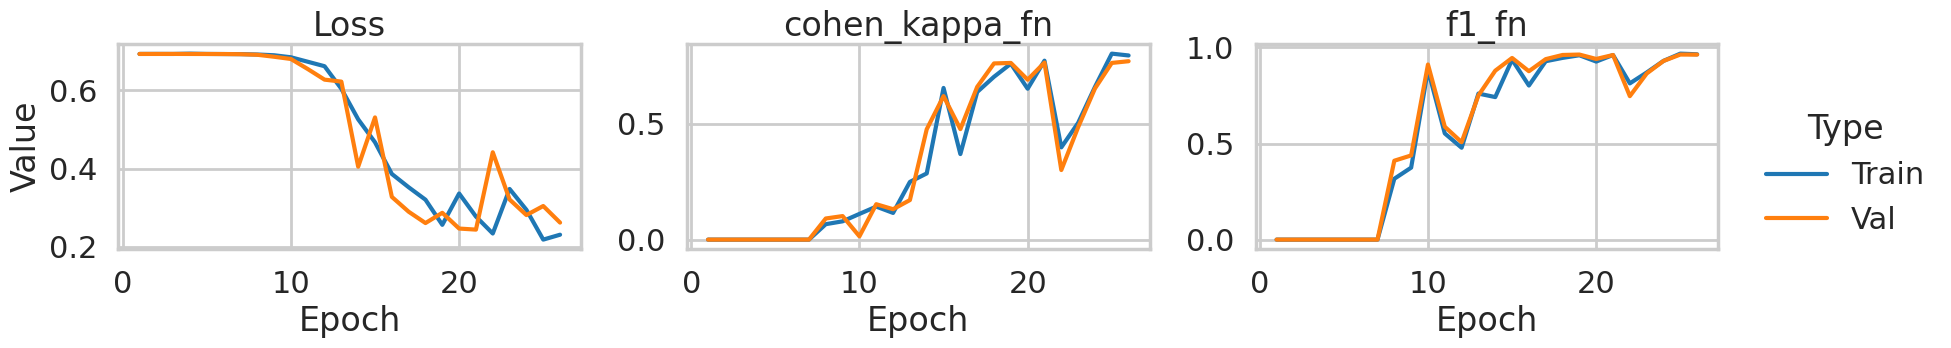

In [ ]:
trainer_cnn_3.plot_epochs()

In [ ]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2713 | Test cohen_kappa_fn: 0.7435 | Test f1_fn: 0.9591


#### Visualization

In [ ]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

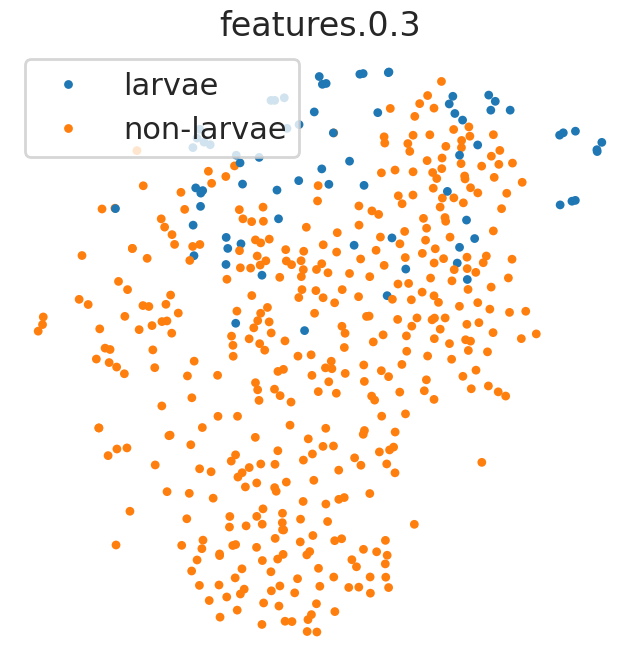

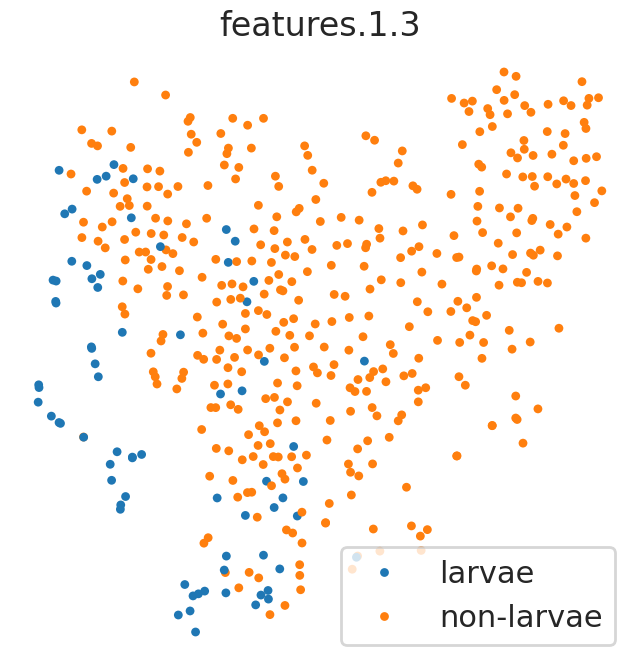

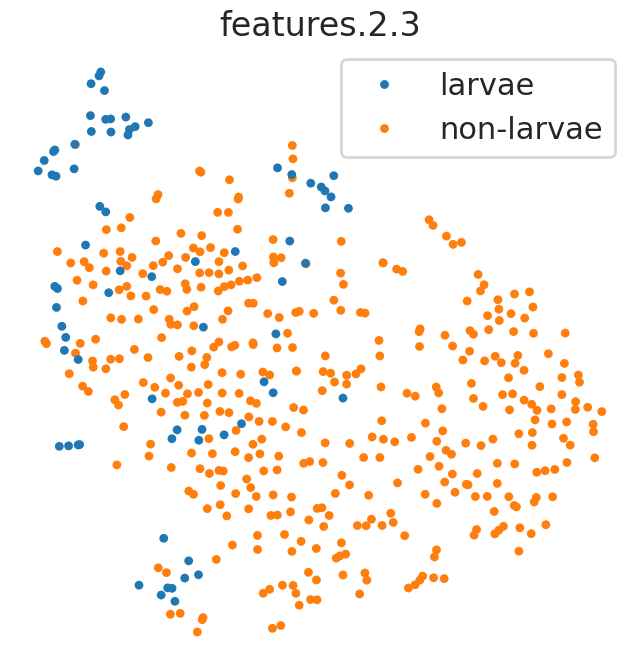

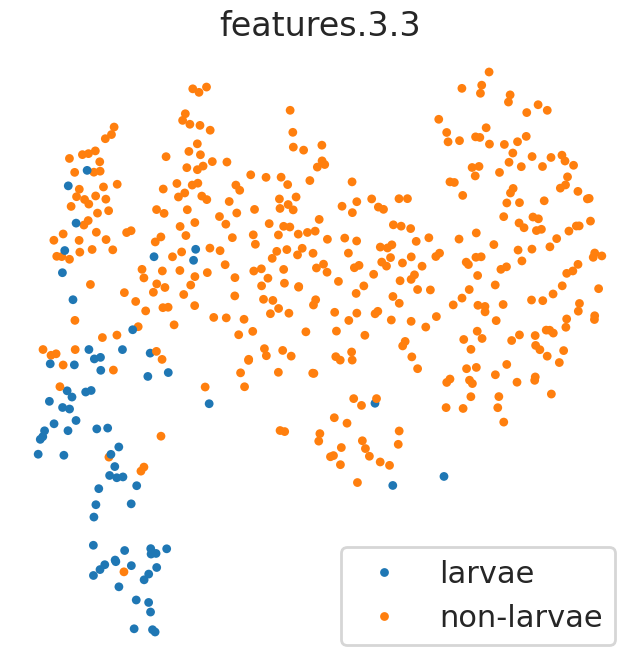

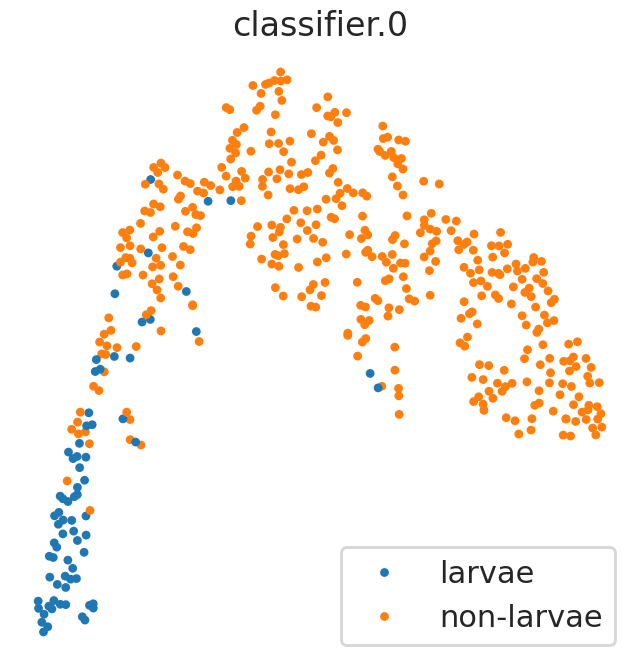

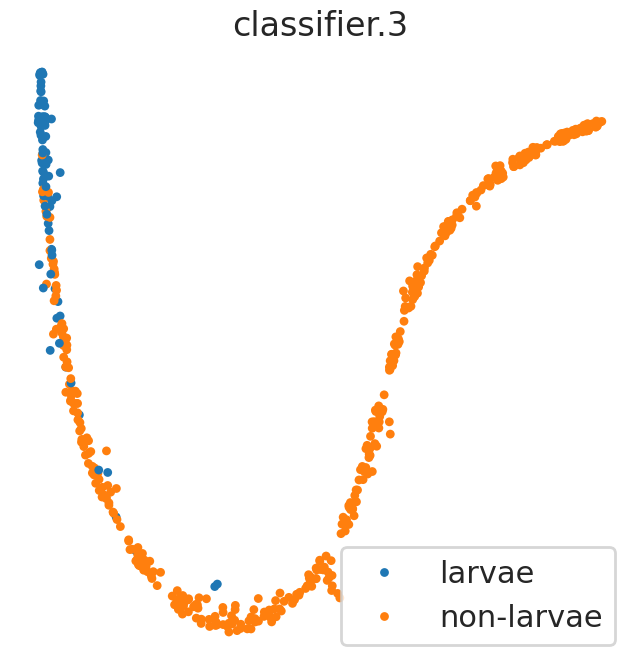

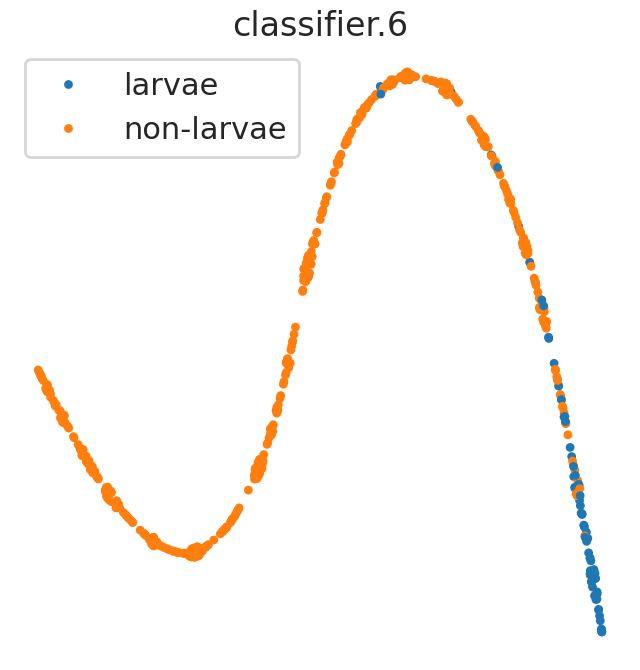

In [ ]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


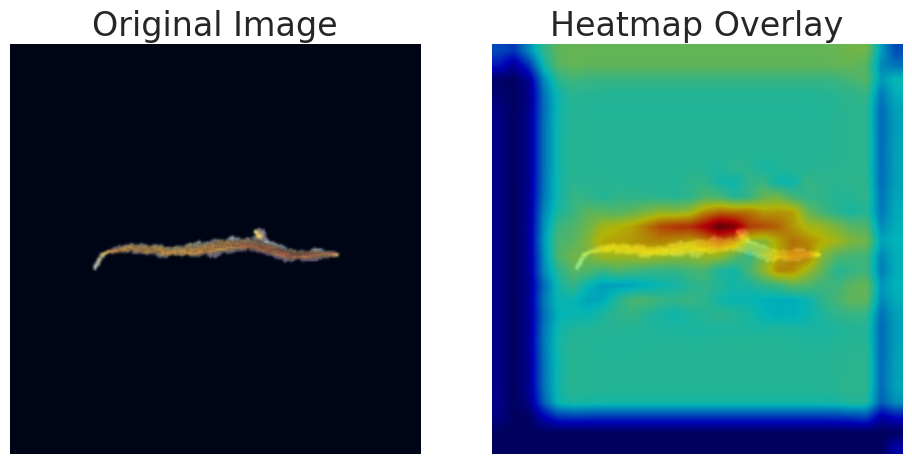

  Generating heatmap for Larvae...
  Predicted label is Larvae!


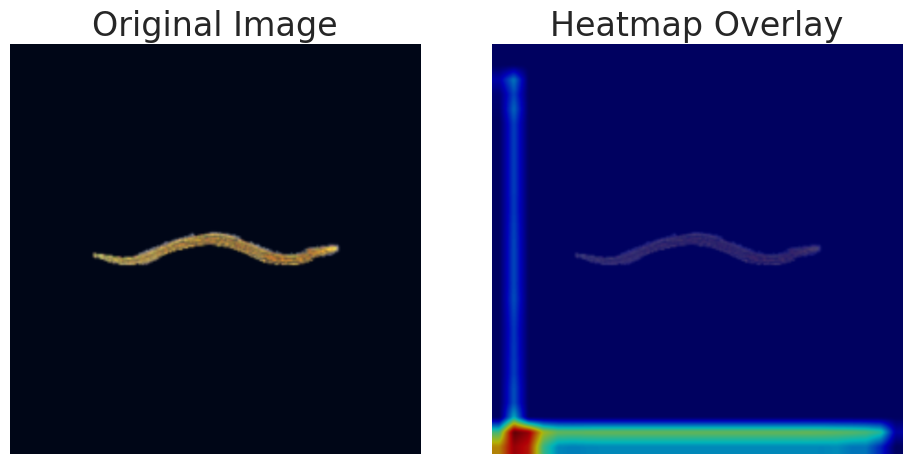

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break